# Facebook-Data-Preprocessing&EDA (Unemployment)
by Allen Huang

In [1]:
import re
import string
import nltk
import random
import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gensim.models import word2vec
from textblob import TextBlob
from sklearn.manifold import TSNE
from datetime import datetime
from textblob.sentiments import NaiveBayesAnalyzer
from tqdm._tqdm_notebook import tqdm_notebook
from pandarallel import pandarallel
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer,)
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS

pandarallel.initialize(progress_bar=True,nb_workers=3)
tqdm_notebook.pandas()
pd.options.mode.chained_assignment = None
pd.set_option('max_colwidth',500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

for resource in 'stopwords', 'punkt', 'wordnet','movie_reviews':
    nltk.download(resource)

/Users/hkmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`

/Users/hkmac/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /Users/hkmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hkmac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hkmac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/hkmac/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


## Load data

In [2]:
def open_file(PATH):
    with open(PATH, "r") as r:
        # read and remove unicode
        content = re.sub(r'\\\w[0|2]0\w{2}\w?', '', r.read()).replace(",","").replace('"','')
        content = re.sub(r'\\u[d|0|2|f|3|c|b]\w{3}', '', content).split("\\n")
        # # remove empty string
        while '' in content:
            content.remove("")
    
    return content
            
content = open_file("original_dataset/Facebook_Unemployment_Content.json")

In [3]:
del content[:2]

*Some underlying rules in our data:*

###### Example
'You can update your address on your phone tablet or computer! Submit your change of address from home in minutes at https://moversguide.usps.com/mgo/disclaimer **Kelly Curry-Sugarman**'

'Why do you lose so many packages this time of year? 3 years in a row not COVID related.. I spent a week of vacation on the phone first week in July the year before last and I had packages missing last June too. I a power seller on EBAY this doesn happen at Christmas Why June and July? Why do you not train people that fill in for vacations to scan packages? It the 25th I have yet ANOTHER lost package and angry customer!!!! Package has not been scanned since June 14th!! Why? UPDATE: Since I POSTED This ANOTHER PACKAGE NOT MOVING FOR 5 days...'

###### Example
'James Jacobs replied  1 reply  **Blane Harry**',
 "Why doesn't my mail man pick up my mail. He hasn't picked my mail for 4 days. And they are Important bills that have to be paid. Lakeview Apartments Galeville New York. Just outside of the town is Liverpool New York.",
 '2  Like  React  Reply  More  Jun 25 at 6:50 PM'
 
###### Example
"4  Like  React  Reply  More  Jun 26 at 7:34 AM **La'Keisha D Watson**",
 "I haven't received my mail in a week and the local office keeps giving me the runaround. I sent emails with no result. I am disabled and it's hard for me to get to the local office. How can this be resolved??????? I also sent a pm to this page",
 '3  Like  React  Reply  More  Jun 25 at 6:28 PM',
 
###### Example
5 replies **Tina Stillions-McAferty**
Thank you postal workers for all you do. Stay safe
12  Like  React  Reply  More  Apr 27

In [4]:
# show a random piece 
random_int = random.randint(0,len(content)-11)
content[random_int:random_int+20]

['Like  React  Reply  More  Jun 17 Lee Cin',
 "Go to Vanessa Brito here on FB she's been helping with the fight against these fools!",
 '1  Like  React  Reply  More  Jun 16 Eric Rasmussen',
 'Pay your claims! I haven got anything since March!',
 '3  Like  React  Reply  More  Jun 16 Elizabeth Garcia',
 'Nobody helping in that number...they hung on you',
 '1  Like  React  Reply  More  Jun 16  View more comments  View previous comments Roni J. Isom',
 'FLORIDA= TOTAL FAILURE',
 'Like  React  Reply  More  Jun 17 Samantha Mcvicker',
 'What happens when your 12 weeks ends and you are still on furlough ?',
 '1  Like  React  Reply  More  Jun 16',
 'Andrew Lerner replied  5 replies  Lee Cin',
 'PAY UP',
 'PAY UP',
 'PAY UP',
 'PAY UP',
 'PAY UP',
 'PAY UP',
 'PAY UP',
 'PAY UP']

## Feature Extraction

In [5]:
text = []
like = []
date = []
reply_to = []
text = []
name = [] 

def is_break_point(astring:str):
    if 'React' in astring:
        return True
    if len(re.findall(r"replied\s+\d+\s+repl\w*",astring)) != 0:
        return True
    if len(re.findall(r"\d*\s+repl\w*",astring)) != 0:
        return True
    else:
        return False
    
def find_like(astring:str):
    like = re.findall(r"\d+\.?\d*",astring[:20])
    if len(like) == 0:
        return 0
    else:
        return like[0]
    
def find_name(astring:str):
    pattern = re.compile(r"[A-Z]\w*\s[A-Z]?['|.]?[A-Z]+\w*")
    matches = pattern.findall(astring)

    if len(matches) == 0:
        return False
    else:
        return matches[0]
    
def find_name_by_time(astring:str):
    name = ""
    # when we have specific time 
    if 'AM' in astring or 'PM' in astring:
        for i in range(len(astring)):
            if astring[i] == 'M' and astring[i-1] in ["A","P"]:
                name = astring[i+1:].strip()
    elif 'ago' in astring:
        for i in range(len(astring)):
            if astring[i:i+3] == 'ago':
                name =  astring[i+4:].strip()

    else:
        pattern = re.compile(r"\w{3} \d+")
        matches = pattern.findall(astring)
        index = astring.index(matches[0])
        name = astring[index+len(matches[0]):].strip()
            
    if len(name) > 50:
        name = find_name_by_view_post(name)
    return name
                
                
def find_name_by_view_post(astring:str):
    for i in range(len(astring)):
        if astring[i:i+9] == 'View post':
            return astring[i+10:].strip()
    
        
def find_name_by_replies(astring:str):
    name = ""
    for i in range(len(astring)):
        if 'View post' in astring:
            return find_name_by_view_post(astring)
        if astring[i:i+5] == 'reply':
            name = astring[i+6:].strip()
        if astring[i:i+7] == 'replies':
            name = astring[i+8:].strip()
    if len(name) > 0:
        return name
    else:
        return find_name(astring)
        
def find_date(astring:str):
    pattern = re.compile(r"\w{3} \d+")
    matches = pattern.findall(astring)
    
    if len(matches) == 0:
        return None
    else:
        return matches[0]
# the first name is in the post description
name.append('Kelly Curry-Sugarman')

for i in range(len(content)):
    # reach the break point
    if 'React' in content[i]:
        date.append(find_date(content[i]))
        like.append(find_like(content[i]))
        
        current = i-1
        long_text = ""
        # combine one's comments at the same time
        while not is_break_point(content[current]):
            long_text += content[current] + ' '
            current -= 1
        text.append(long_text)
        
        # extract reply_to information
        if find_name(long_text[:40]):
            if long_text.split(" ")[1] == 'I':
                reply_to.append("")
            else:
                reply_to.append(find_name(long_text[:40]))
        else:
            reply_to.append("")
        
        if 'React' in content[current]:
            try:
                name.append(find_name_by_time(content[current]))
            except Exception:
                name.append("")
                
        if len(re.findall(r"replied\s+\d+\s+repl\w*",content[current])) != 0:
            name.append(find_name_by_replies(content[current]))
        
        elif len(re.findall(r"\d*\s+repl\w*",content[current])) != 0:
            name.append(find_name_by_replies(content[current]))
            

del name[1]

df = pd.DataFrame({"name":name,"text":text,"date":date,"like":like,"reply_to":reply_to})

In [6]:
drop_index = list(df.query("name == '' or name == False or name == None").index)
drop_index.extend(list(df.query("text == ''").index))

In [7]:
df.drop(set(drop_index),inplace=True)
df.dropna(subset=['name'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [8]:
df.head(20)

name  \
0                       Kelly Curry-Sugarman   
1                    Niko Nikolopoulos Greek   
2                            FILING FAILURES   
3                           Theresa Odonnell   
4                      Mary Middleton Miller   
5                                 Peter Herr   
6                              Tim Tallmadge   
7                              Mike Skarakis   
8                                Hunter File   
9                                 Mark Suess   
10                                Mark Suess   
11                             Brooke Walker   
12                           Cris Bierschank   
13     View previous comments Janice Hensley   
14                             Mike Skarakis   
15                              Carynn Silva   
16  Missing FPUC since May 19th Request Form   
17                               Buddy Orton   
18                               Kendra Gale   
19                           Anthony Sposaro   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0                                                                                                                                                                                                                     Under these times you should have unemployment offices being open there's plenty of space available around different towns and there's plenty of people that need a job and can help others even if it's temporary start helping the people and cut the red tape only you can do it Ron DeSantis    
1                                                                                                                                                                                                                                                                                                                                                                                  docs.google.com FILING FAILURES https://docs.google.com/forms/d/e/1FAIpQLSc91OyMZH5xGh3-0-Maf58ig9cG5MixQ6h23AWtqlEI-7E81Q/viewform    
2   All of the problems that the DEO has is because they do not communicate with their clients. I have gotten 1 letter since the end of March when I filed. That was Monetary Determination now to me that paperwork shows how much I made from the company I worked for. It also showed the amount of money the DEO determined I was entitled to both weekly and maximum. There was no mention of filing an appeal or anything negative on the account. I tried for months now to contact them and I am still tryin...   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Perhaps a hacker can unlock my account!    
4                                                                                                                                                                                   How about actually answering the phone respond to emails or answer pleas for help across social media? If you lifted one finger to help we would not be in need to reach out to others for help. Your post is insulting and judgmental to those who are pleading for help. I realize your job is to deflect but this is hear

## Feature Engineering

### Remove duplicate comments

In [9]:
# remove duplicate comments
print(f"Number of comments before removing duplication: {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Number of comments after removing duplication: {len(df)}")
df.reset_index(drop=True,inplace=True)

Number of comments before removing duplication: 2645
Number of comments after removing duplication: 2387


### Time series data

In [10]:
# deal with time data
date_index = df[df.date.notnull().values==True].index
df.date = df.iloc[date_index].date.apply(lambda x: datetime.strptime(f'{x} 2020', '%b %d %Y'))

In [11]:
df['day'] = df.date.dt.day
df['month'] = df.date.dt.month
df['dayofweek'] = df.date.dt.dayofweek
df.head()

name  \
0     Kelly Curry-Sugarman   
1  Niko Nikolopoulos Greek   
2          FILING FAILURES   
3         Theresa Odonnell   
4    Mary Middleton Miller   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0                                                                                                                                                                                                                    Under these times you should have unemployment offices being open there's plenty of space available around different towns and there's plenty of people that need a job and can help others even if it's temporary start helping the people and cut the red tape only you can do it Ron DeSantis    
1                                                                                                                                                                                                                                                                                                                                                                                 docs.google.com FILING FAILURES https://docs.google.com/forms/d/e/1FAIpQLSc91OyMZH5xGh3-0-Maf58ig9cG5MixQ6h23AWtqlEI-7E81Q/viewform    
2  All of the problems that the DEO has is because they do not communicate with their clients. I have gotten 1 letter since the end of March when I filed. That was Monetary Determination now to me that paperwork shows how much I made from the company I worked for. It also showed the amount of money the DEO determined I was entitled to both weekly and maximum. There was no mention of filing an appeal or anything negative on the account. I tried for months now to contact them and I am still tryin...   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Perhaps a hacker can unlock my account!    
4                                                                                                                                                                                  How about actually answering the phone respond to emails or answer pleas for help across social media? If you lifted one finger to help we would not be in need to reach out to others for help. Your post is insulting and judgmental to those who are pleading for help. I realize your job is to deflect but this is heartless.    

        date like         reply_to   day  month  dayofweek  
0 2020-06-09    4                    9.0    6.0        1.0  
1 2020-06-10    0  FILING FAILURES  10.0    6.0        2.0  
2 2020-06-09    2                    9.0    6.0        1.0  
3 2020-06-10    1                   10.0    6.0        2.0  
4 2020-06-10    0                   10.0    6.0        2.0

### Reply to relationship

In [12]:
while False in name:
    name.remove(False)
    
while None in name:
    name.remove(None)

In [13]:
# create a dictionary to store full name 
name_dict = {}

for part_name in tqdm_notebook(df.reply_to):
    for full_name in set(name):
        if (part_name in full_name) & (len(part_name) > 0):
            if part_name not in name_dict.keys():
                name_dict[part_name] = full_name

In [14]:
df['reply_to'].replace(name_dict, inplace=True)

In [15]:
# check if all of the names in reply_to match the exact name
unmatched_name = []
for part_name in tqdm_notebook(df.reply_to):
        if (part_name not in name) & (len(part_name) > 0):
            unmatched_name.append(part_name)
            
unmatched_name[:20]

['AND STILL',
 'Pay Us',
 'Actual DEO',
 'WHERE ARE',
 'So I',
 'And New',
 'Florida Demonstrators',
 'WHERE ARE',
 'FEDERAL MONEY',
 'Celina Wynn',
 'Labor Depar',
 'Sarah Mae',
 'Good Now',
 'Does Federal',
 "Connect 'Manage",
 'NO ONE',
 'HUMAN ERROR',
 'YALL REALLY',
 'WAITING ROOM',
 'Govenor Ron']

In [16]:
unmatched_index = df.query(f"reply_to in {unmatched_name}").index
df.loc[unmatched_index,'reply_to'] = ''

## Tokenization & Lemmatization

In [17]:
def preprocessing(line: str):
    transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    lemmatizer = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    
    line = line.replace('<br />', '').translate(transtbl)
    
    tokens = [lemmatizer.lemmatize(t.lower(),'v') 
              for t in nltk.word_tokenize(line) 
              if t.lower() not in stopwords] 

    return ' '.join(tokens)

In [18]:
df['text_prep'] = df['text'].parallel_apply(preprocessing)

## Explantory Data Analysis

### Word Cloud

In [47]:
def plot_word_cloud(df, feature_name):
    # back_coloring = mpimg.imread(back_coloring)
    str_Cloud = " ".join(df[feature_name])
    
    wc = WordCloud(# font_path='simsun.ttf',  
               background_color="black",  
               width=600,height=300,
               min_font_size=10,
               stopwords=STOPWORDS,
               max_words=5000,  
               # mask=back_coloring, 
               max_font_size=120, 
               random_state=42,
               collocations=False,
               colormap = 'cool').generate(str_Cloud)
    # image_colors = ImageColorGenerator(back_coloring)
    plt.figure(figsize=(60,30))
    plt.imshow(wc)
    plt.axis("off")
    # plt.savefig("word_cloud.jpeg")
    plt.show()

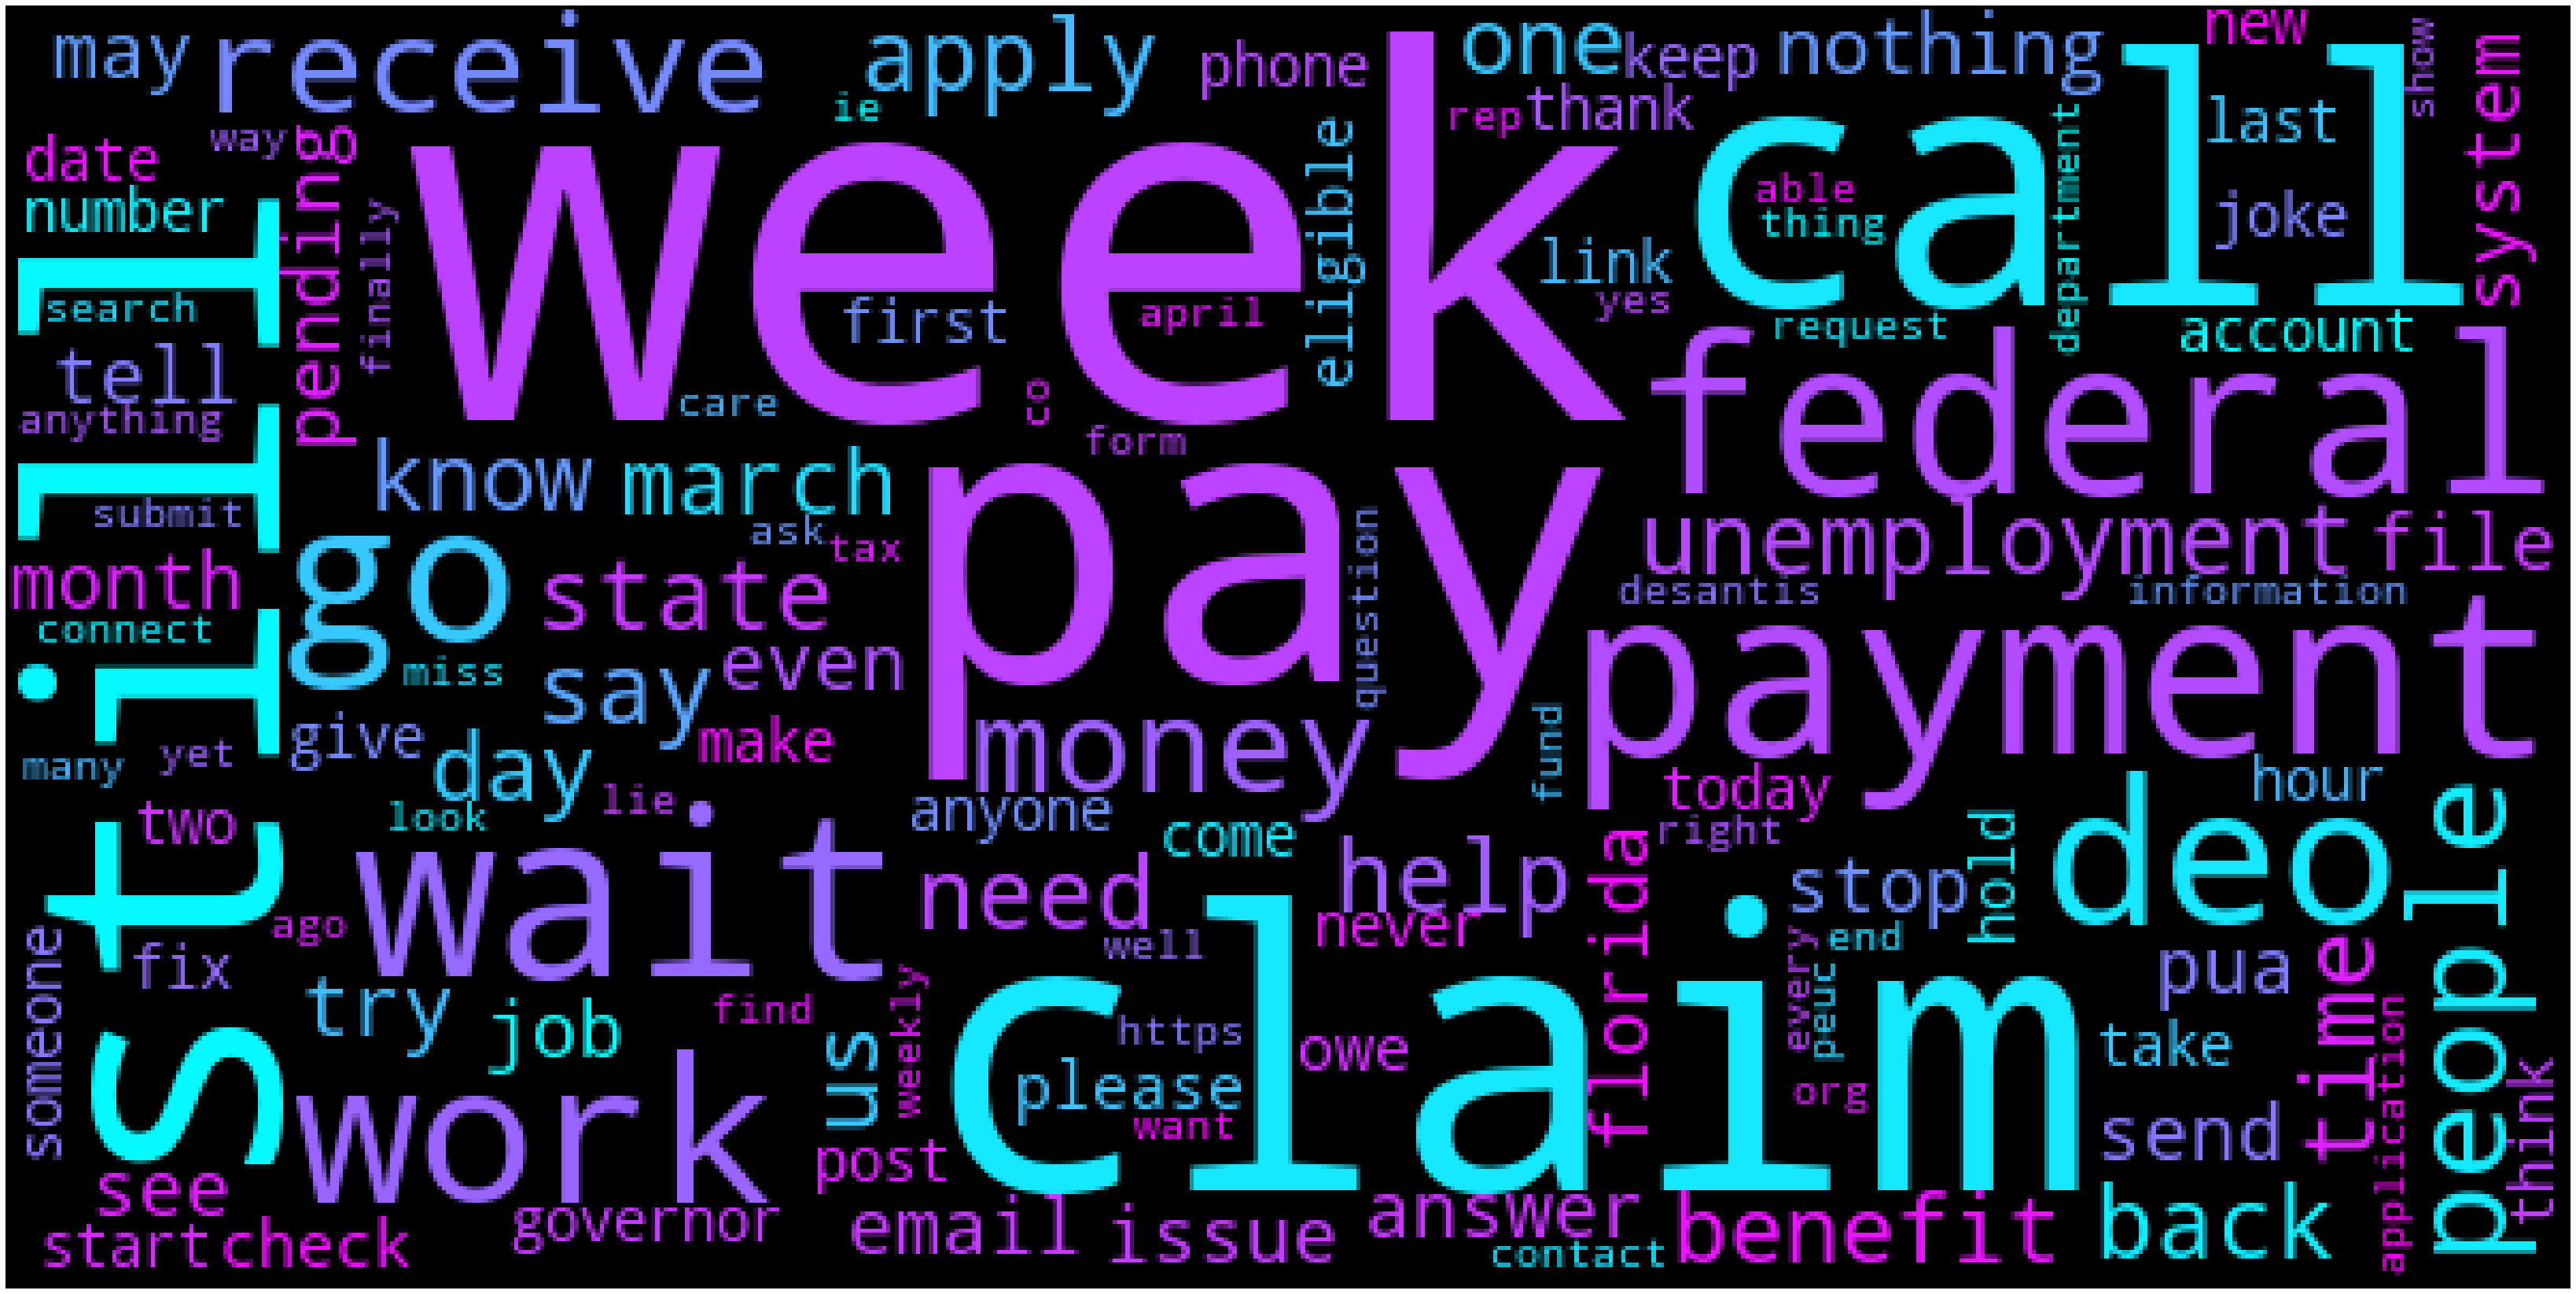

In [48]:
plot_word_cloud(df,'text_prep')

### Most Commen Words

In [49]:
name_lower = [] 
for i in set(name):
    name_lower.append(i.lower())

In [50]:
def plot_most_common_words(df, column, threshold, n):
    vec = CountVectorizer(ngram_range=(n,n), max_features=2000).fit(df[column])
    bag_of_words = vec.transform(df[column])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    
    for i in words_freq:
        if i[0] in name_lower:
            words_freq.remove(i)
    
    x = [i[0] for i in words_freq[:threshold]]
    y = [i[1] for i in words_freq[:threshold]]
    
    most_common = pd.DataFrame({"word":x,"count":y})
    fig = px.bar(most_common, x="word", y='count',
                color='count', height=400)
    fig.update_layout(title_text=f'Most Common Words ({n}-grams)',title_x=0.5)
    fig.show()    

In [51]:
for i in [1,2]:
    plot_most_common_words(df,'text_prep',10,i)

### Most Active Replier 

In [52]:
threshold = 10

df_top_active = df.groupby("name").count().sort_values(by='text',ascending=False)[:threshold].reset_index()

fig = px.bar(df_top_active, x="name", y='text',
            color='text', height=400,
            labels={'text':'count','name':'replier'})
fig.update_layout(title_text='Most Active Replier',title_x=0.5)
fig.show()

### Time series plot

In [53]:
df_time_series = df[df.date.notnull()]

In [54]:
df_time_series.isnull().sum()

name         0
text         0
date         0
like         0
reply_to     0
day          0
month        0
dayofweek    0
text_prep    0
dtype: int64

In [55]:
df_time_series['month'] = df_time_series['month'].apply(lambda x: int(x))
df_time_series['day'] = df_time_series['day'].apply(lambda x: int(x))
df_time_series['dayofweek'] = df_time_series['dayofweek'].apply(lambda x: int(x))

In [56]:
df_time_series.drop(df_time_series.query("month == 12").index, inplace=True)

In [57]:
data_by_month = df_time_series.groupby("month").count().reset_index()

In [58]:
fig = px.bar(data_by_month, x="month", y="name", 
             color="name", text='name',
            labels={"month":"month","name":"cont"})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Total Comments (by month)', title_x=0.5)
fig.show()

In [59]:
data_by_dayofweek = df_time_series.groupby("dayofweek").count().reset_index()

fig = px.bar(data_by_dayofweek, x="dayofweek", y="name", 
             color="name", text='name',
            labels={"dayofweek":"dayofweek","name":"count"})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Total Comments (by day of week)', title_x=0.5)
fig.show()

In [60]:
data_by_date = df_time_series.groupby(["date"]).count().reset_index()

fig = px.line(data_by_date, x='date', y='name',
             labels={"name":"count"})
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ))
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Total Comments (by date)', title_x=0.5)
fig.show()

### Polarization 

#### Sentiment Classification 

In [61]:
df['polarity'] = df['text_prep'].parallel_apply(lambda x: round(TextBlob(x).polarity,3))

In [62]:
df['subjectivity'] = df['text_prep'].parallel_apply(lambda x: round(TextBlob(x).subjectivity,3))

In [63]:
df.polarity.describe()

count    2387.000000
mean        0.027529
std         0.229613
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.050000
max         1.000000
Name: polarity, dtype: float64

In [64]:
df.subjectivity.describe()

count    2387.000000
mean        0.248311
std         0.310157
min         0.000000
25%         0.000000
50%         0.033000
75%         0.484000
max         1.000000
Name: subjectivity, dtype: float64

In [65]:
# labeling subjectivity
def subjectivity_labeling(df,threshold=0.5):
    if threshold == 0.5:
        df.loc[df.subjectivity > 0.5,"subjectivity_label"] = 'subjective'
        df.loc[df.subjectivity < 0.5,"subjectivity_label"] = 'objective'
        df.loc[df.subjectivity == 0.5,"subjectivity_label"] = 'natural'
    else:
        df.loc[df.subjectivity >= threshold,"subjectivity_label"] = 'subjective'
        df.loc[df.subjectivity <= (1-threshold),"subjectivity_label"] = 'objective'
        df.loc[df.subjectivity < 0.5 and df.subjectivity > (1-threshold),"subjectivity_label"] = 'natural'
        
    return df

def polarity_labeling(df,threshold=0):
    if threshold == 0:
        df.loc[df.polarity > 0,"polarity_label"] = 'positive'
        df.loc[df.polarity < 0,"polarity_label"] = 'negative'
        df.loc[df.polarity == 0,"polarity_label"] = 'natural'
    else:
        df.loc[df.polarity >= threshold,"polarity_label"] = 'positive'
        df.loc[df.polarity <= (-threshold),"polarity_label"] = 'negative'
        df.loc[df.polarity < 0 and df.subjectivity > (-threshold),"polarity_label_label"] = 'natural'
        
    return df

In [66]:
df = subjectivity_labeling(df)
df = polarity_labeling(df)

In [67]:
df.sample(3)

name  \
1400             Dan Held   
2040         Abby Laciste   
1043  Jewell Fifer Staton   

                                                                                                                                                                                                                                                                                                                                                                                                               text  \
1400                                                                                                                                                                                                                                                                                                                                                               The only RAUD is the one the DEO is committing     
2040                                                                                                                                                                                                                                                                                                                                                              Wanda Lehman same it literally just stopped 5/19    
1043  Approved and in Adjudication Abyss SINCE MARCH!!!! was out Until JUNE 1st. Been back to work a month now (facing another industry shut down due to Covid19) and I'm still waiting for ALL the state UE due me as well as at least 5 Federal payments( hard to know the beginning since ONLY DEO can track that portion) where is my $5410-$235.(says over payment from 2017) = 5. you have my direct deposit    

           date like      reply_to   day  month  dayofweek  \
1400 2020-06-11    0                11.0    6.0        3.0   
2040 2020-06-14    2  Wanda Lehman  14.0    6.0        6.0   
1043        NaT    0                 NaN    NaN        NaN   

                                                                                                                                                                                                                                          text_prep  \
1400                                                                                                                                                                                                                            raud one deo commit   
2040                                                                                                                                                                                                               wanda lehman literally stop 5 19   
1043  approve adjudication aby since march june 1st back work month face another industry shut due covid19 still wait state ue due well least 5 federal payments hard know begin since deo track portion 5410 235 say payment 2017 5 direct deposit   

      polarity  subjectivity subjectivity_label polarity_label  
1400     0.000         0.000          objective        natural  
2040     0.000         0.000          objective        natural  
1043    -0.124         0.349          objective       negative

In [70]:
# save the dataset with sentiment if needed
if True:
    df.to_csv("preprocessed_dataset/Facebook_preprocessed_Unemployment.csv")

#### Sentiment Overview

In [71]:
fig =px.sunburst(
    df.groupby(["polarity_label",'subjectivity_label']).count().name.reset_index(),
    path=['polarity_label', 'subjectivity_label'],
    values='name',color='name',
    color_continuous_scale='RdBu')
fig.update_layout(title_text='Sentiment Distribution', title_x=0.5)
fig.show()

In [72]:
def plot_people_sentiment(df, polarity_threshold=0,subjectivity_thresould=0.5):
    df = df[(df.polarity > polarity_threshold) | (df.polarity < (-polarity_threshold))]
    df = df[(df.subjectivity > subjectivity_thresould) | (df.subjectivity < (1-subjectivity_thresould))]
    df.like = df.like.apply(lambda x: round(int(x),2))
    fig = px.scatter(df.reset_index(), hover_name="name",
                 x="polarity", y="subjectivity", size="like", color="polarity",
                 log_x=False, size_max=60, labels={'text':'count','name':'replier'})
    fig.update_layout(title_text='Sentiment Overview',title_x=0.5)
    fig.show()
    
plot_people_sentiment(df)

In [73]:
def plot_subjectivity(df, subjectivity_threshold = 0.5, log_y=False):
    df = df[(df.subjectivity > subjectivity_threshold) | (df.subjectivity < (1-subjectivity_threshold))]
    fig = px.histogram(df, x="subjectivity", marginal="box",
                      opacity=0.8, log_y=log_y,
                      color_discrete_sequence=['indianred'])
    fig.update_layout(title_text='Subjectivity Distribution',title_x=0.5)
    fig.show()

plot_subjectivity(df,log_y=True)    

In [74]:
def plot_polarity(df, polarity_threshold = 0):
    df = df[(df.polarity > polarity_threshold) | (df.polarity < (-polarity_threshold))]
    fig = px.histogram(df, x="polarity", marginal="box",
                      opacity=0.8)
    fig.update_layout(title_text='Polarity Distribution',title_x=0.5)
    fig.show()

plot_polarity(df,0)    

#### Positive/Negative Comments Word Cloud

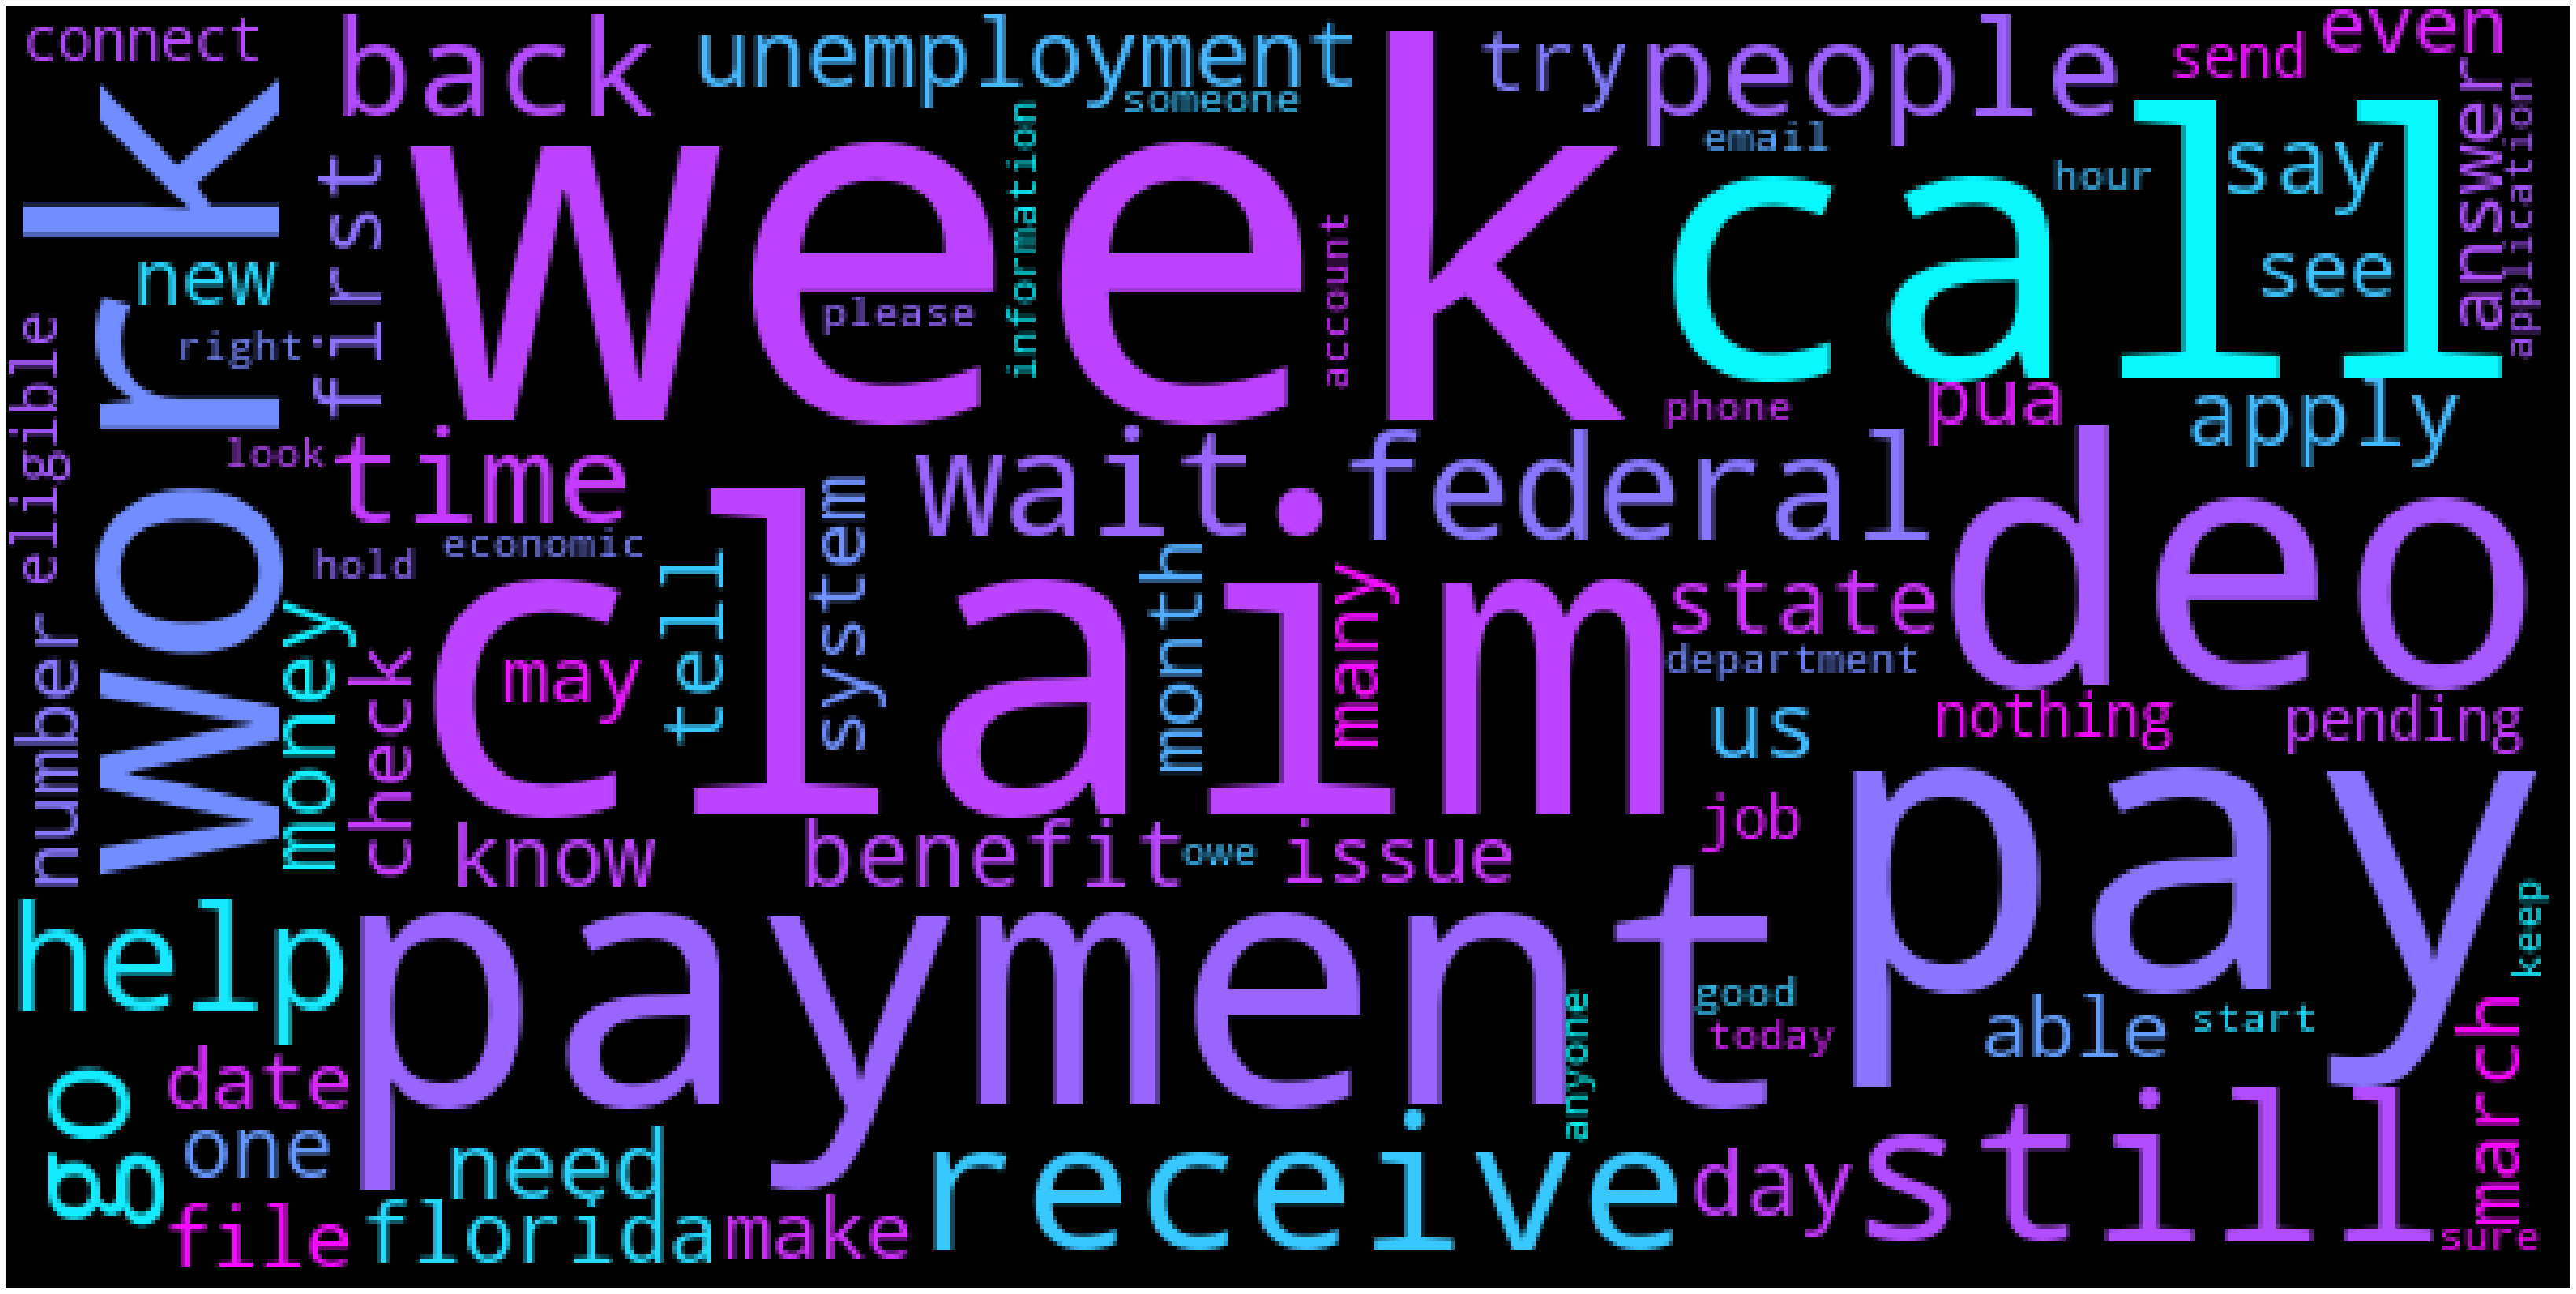

In [75]:
plot_word_cloud(df.query("polarity_label == 'positive'"),'text_prep')

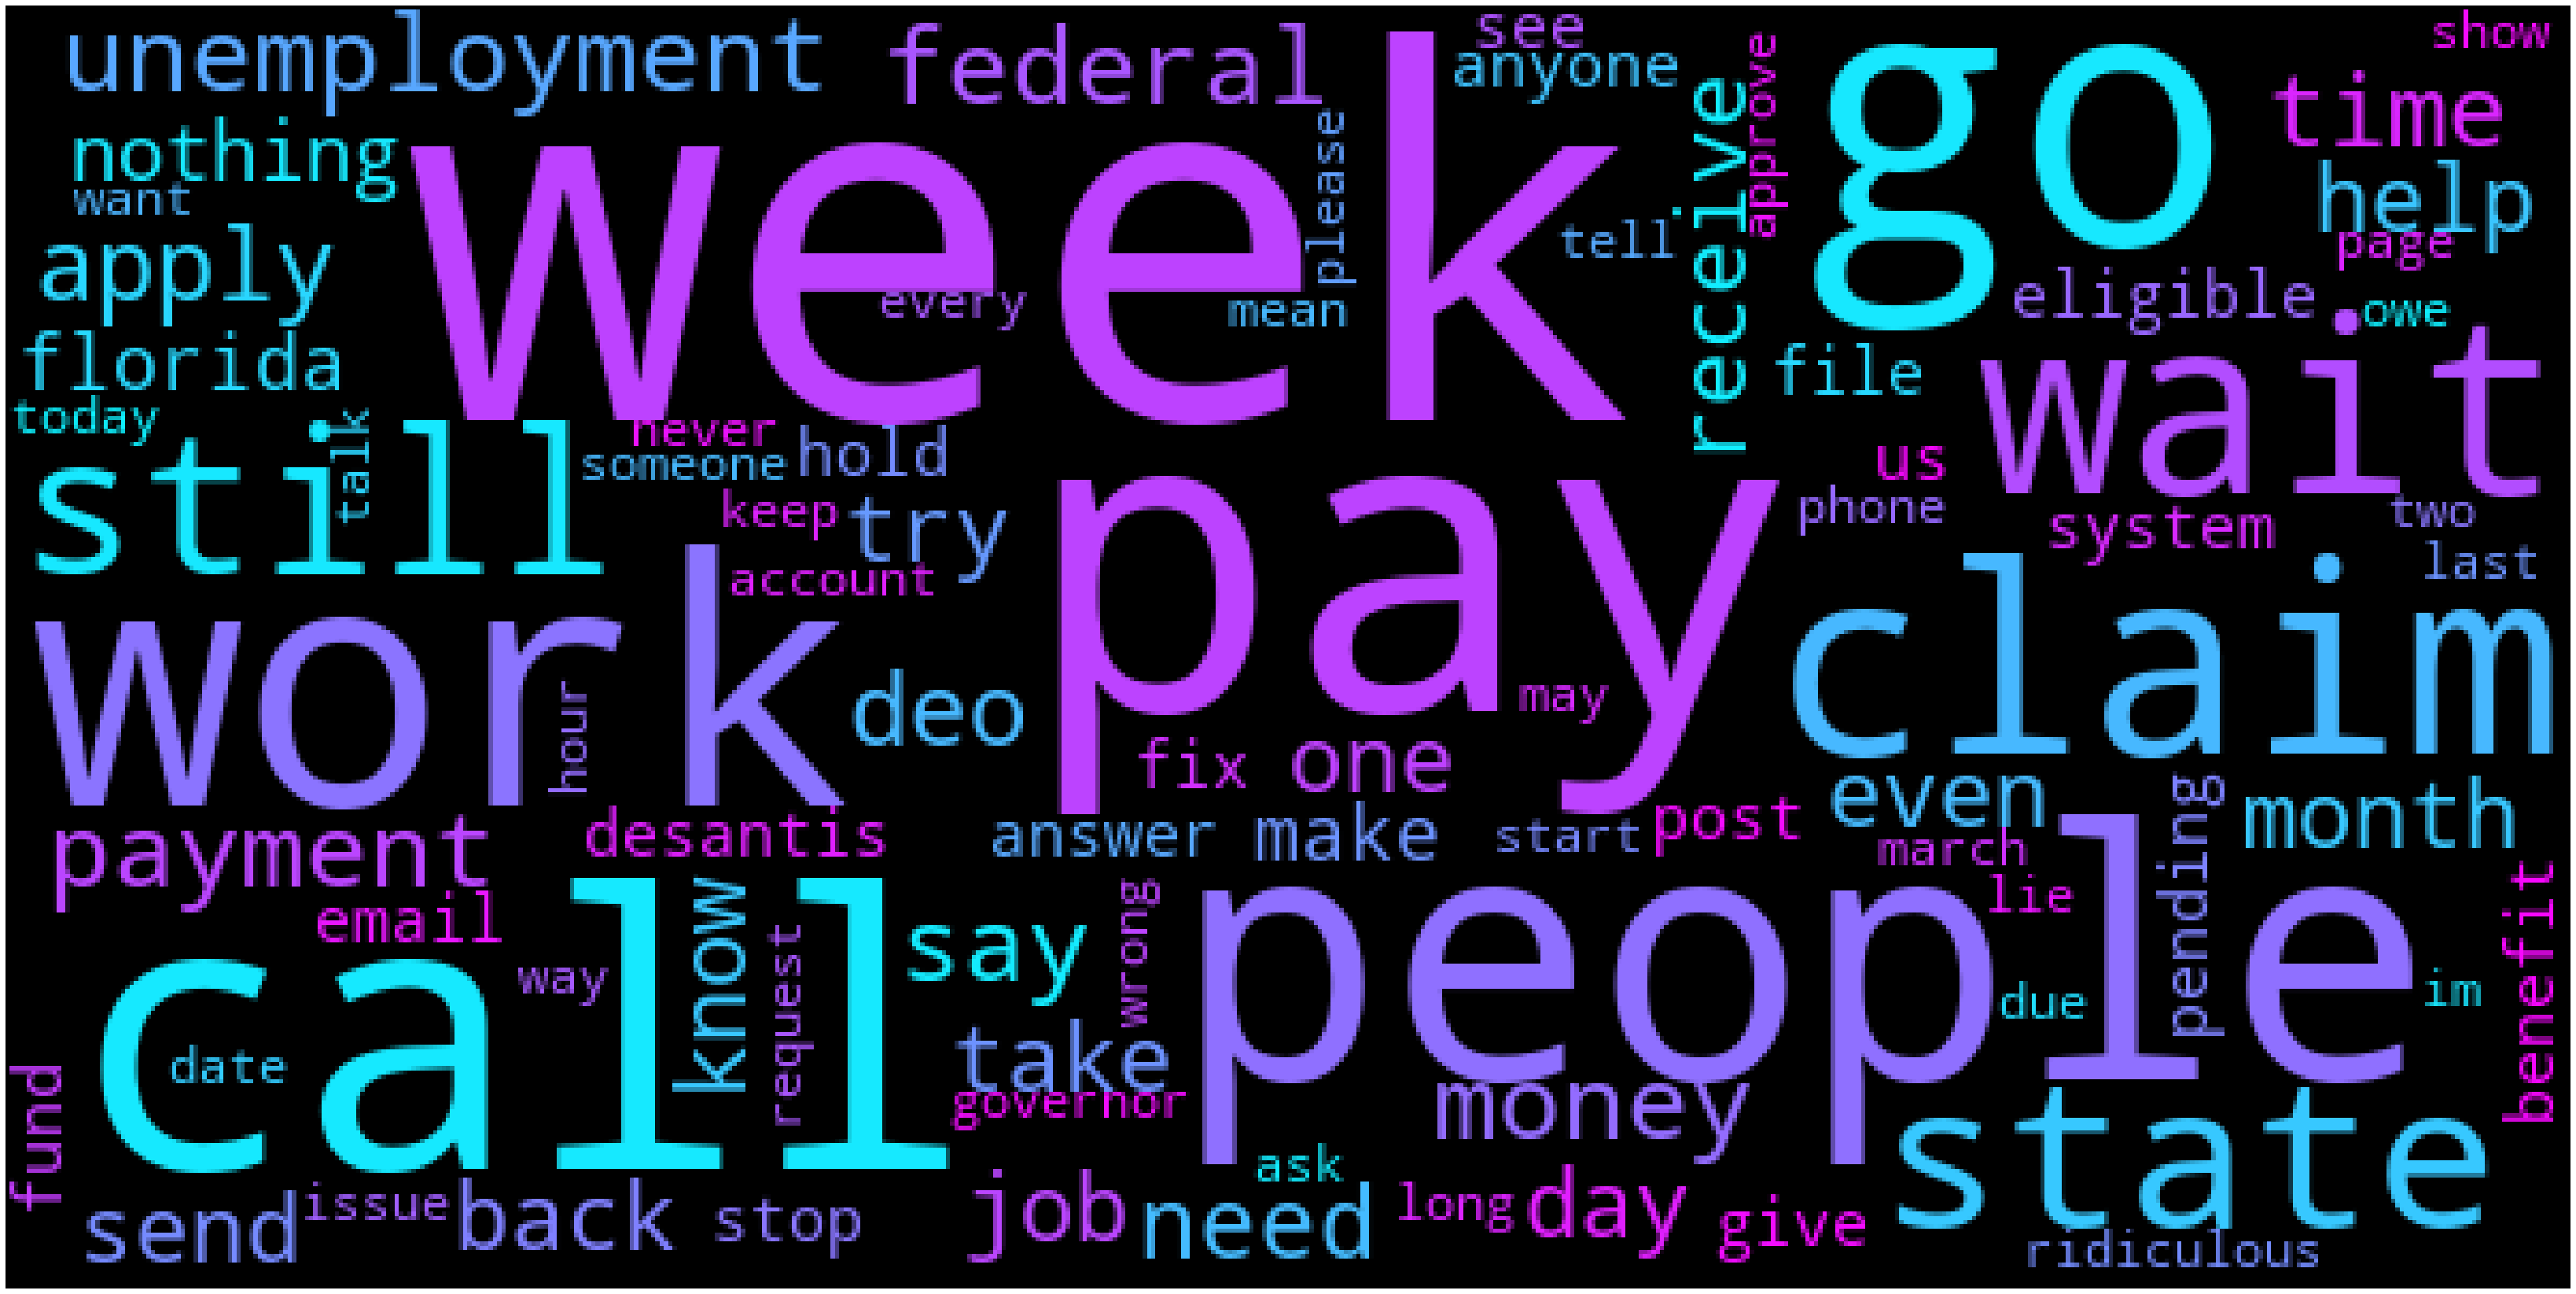

In [76]:
plot_word_cloud(df.query("polarity_label == 'negative'"),'text_prep')

#### Positive/Negative Most Common Words

In [77]:
def plot_senti_most_common_words(dataset, column, sentiment, 
                                 threshold=0, topwords=10, n=1):

    if sentiment == 'positive':
        df = dataset.query(f"polarity_label == '{sentiment}' and polarity >= {threshold}")
    if sentiment == 'negative':
        df = dataset.query(f"polarity_label == '{sentiment}' and polarity <= (-{threshold})")   
        
    vec = CountVectorizer(ngram_range=(n,n), max_features=2000).fit(df[column])
    bag_of_words = vec.transform(df[column])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    
    for i in words_freq:
        if i[0] in name_lower:
            words_freq.remove(i)
    
    x = [i[0] for i in words_freq[:topwords]]
    y = [i[1] for i in words_freq[:topwords]]
    
    most_common = pd.DataFrame({"word":x,"count":y})
    fig = px.bar(most_common, x="word", y='count',
                color='count', height=400)
    fig.update_layout(title_text=f'Most Common Words ({sentiment},{n}-grams)',title_x=0.5)
    fig.show() 

In [78]:
plot_senti_most_common_words(df, 'text_prep','negative',0.2,n=2)

In [79]:
plot_senti_most_common_words(df,'text_prep','positive',0.2,n=2)

#### Positive/Negative Most Active Replier

In [80]:
def most_active_plot(dataset,threshold=10,sentiment='positive'):
    df_senti_active_replier = dataset.query(f"polarity_label == '{sentiment}'").groupby("name").count().sort_values(by='text',ascending=False)[:threshold].reset_index()

    fig = px.bar(df_senti_active_replier, x="name", y='text',
                color='text', height=400,
                labels={'text':'count','name':'replier'})
    fig.update_layout(title_text=f'Most Active Replier ({sentiment})',title_x=0.5)
    fig.show()
    
most_active_plot(df)

In [81]:
most_active_plot(df, sentiment='negative')

#### Time series plot based on polarization/subjectivity

In [82]:
fig = px.histogram(df.loc[df.query("month != 12").index], x="date",
                   color='polarity_label',
                   marginal="rug",
                   opacity=0.8)
fig.show()

In [83]:
fig = px.histogram(df.loc[df.query("month != 12").index], x="date",
                   color='subjectivity_label',
                   marginal="rug",
                   opacity=0.8)
fig.show()

### Social Network Visualization

In [84]:
# create name pair
name_pair = []

for i in tqdm_notebook(range(len(df))):
    if len(df.loc[i,'reply_to']) > 0:
        name_pair.append([df.loc[i,'name'],df.loc[i,'reply_to']])

In [85]:
df_network = pd.DataFrame(name_pair)
df_network.columns = ['replier','reply_to']
df_network.head(10)

replier                                  reply_to
0  Niko Nikolopoulos Greek                           FILING FAILURES
1            Brooke Walker                                Mark Suess
2          Cris Bierschank                                Mark Suess
3             Carynn Silva  Missing FPUC since May 19th Request Form
4             Steve Heroux                                Gia Mariah
5               Gia Mariah                              Steve Heroux
6             Susan Murphy                           Veronica M Finn
7          Carlos Molinari                                   Le Lita
8                  Le Lita                           Carlos Molinari
9          Carlos Molinari                                   Le Lita

In [86]:
df_network.to_csv("output/graph_dataframe_Unemployment.csv")

In [87]:
G = nx.Graph()
G.add_nodes_from(df_network.replier)
G.add_nodes_from(df_network.reply_to)
G.add_edges_from(df_network.values)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 466
Number of edges: 491
Average degree:   2.1073


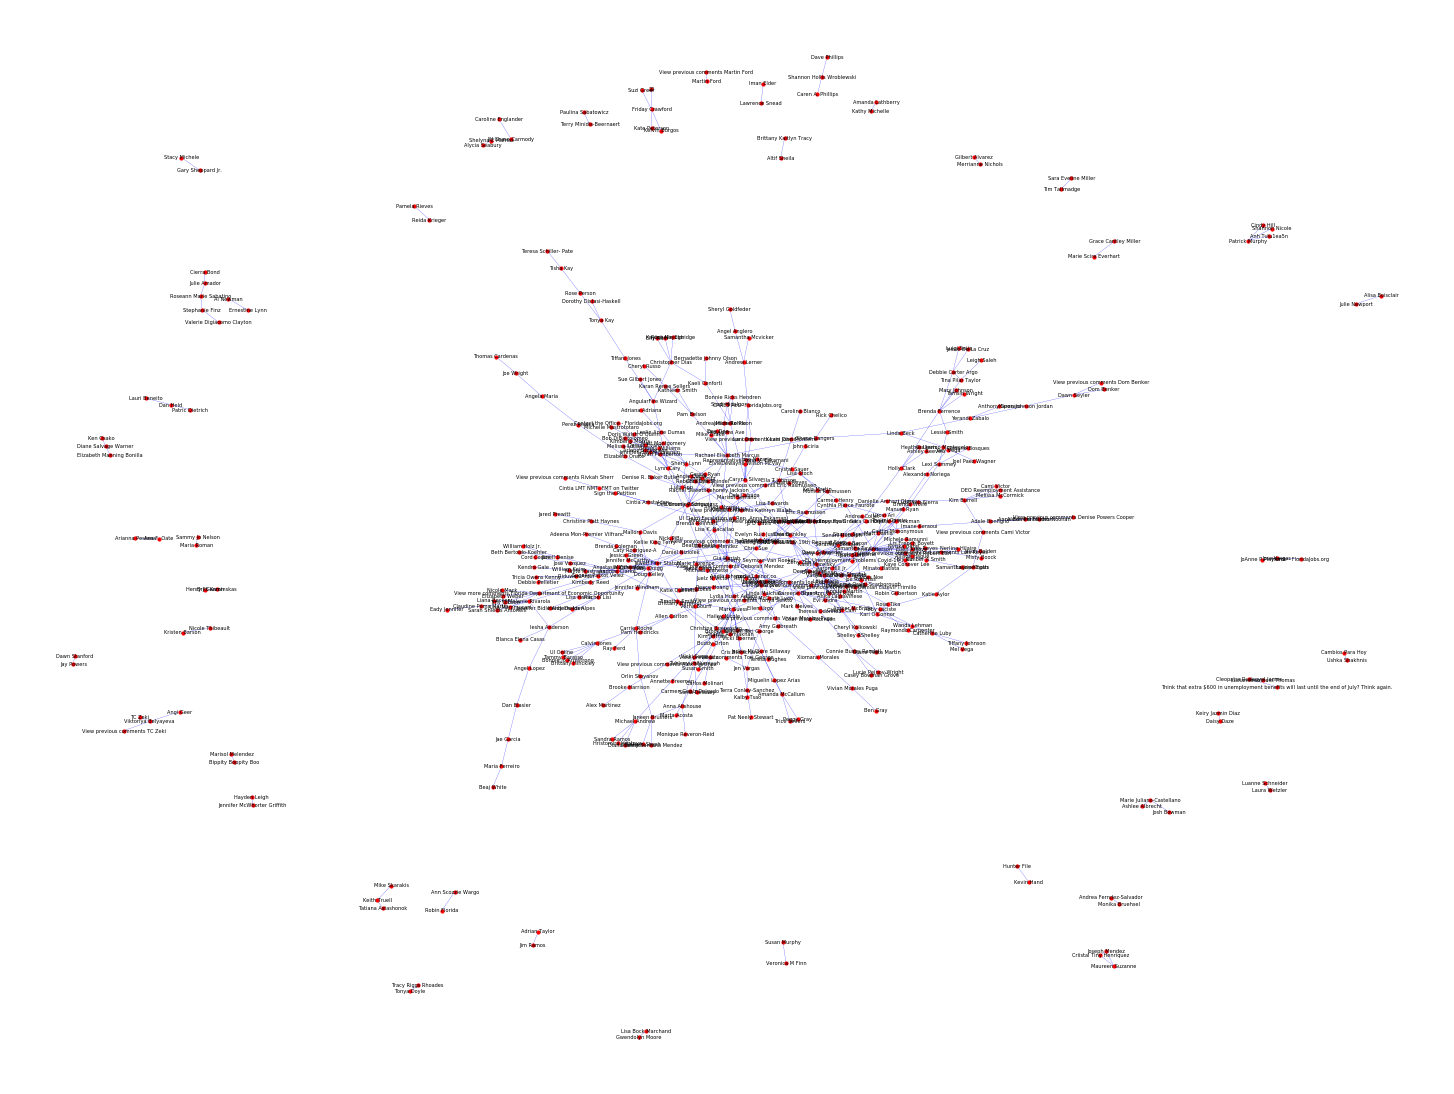

In [89]:
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G)
nx.draw(G,pos,with_labels=True, node_color='r', edge_color='b', node_size=10,
        width=0.2,font_size=5, font_family='sans-serif') 
plt.axis('off')
plt.show()